In [1]:
import os
import imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
from PIL import Image
import tensorflow as tf

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
DATASET_ROOT = '../data/processed'
DATASET_TRAIN = DATASET_ROOT + '/train'
DATASET_TEST = DATASET_ROOT + '/test'

SAVED_MODELS_PATH = '../saved_models'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        DATASET_TRAIN,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        DATASET_TEST,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1615 images belonging to 3 classes.
Found 283 images belonging to 3 classes.


In [6]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

def vgg16_based_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x, name='vgg16_based')
    return model


def residual_block(x, filters_num):
    x_residual = x
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters_num, (3, 3), padding='same')(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters_num, (3, 3), padding='same')(x)
    
    x = tf.keras.layers.add([x, x_residual])
    
    return x


def downsample(x, filters_num):
    x = Conv2D(filters_num, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    return x


def resnet_simple_model():
    model_input = Input(shape=(150, 150, 3))
    x = BatchNormalization()(model_input)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = downsample(x, 128)
    
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    x = downsample(x, 128)
    
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    x = downsample(x, 64)
    
    x = Flatten(name='flatten')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=x, name='simple_residual')
    return model
              
    
model = resnet_simple_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "simple_residual"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 150, 150, 3)  12          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 150, 150, 64) 1792        batch_normalization_18[0][0]     
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 150, 150, 64) 0           conv2d_17[0][0]                  
____________________________________________________________________________________

In [35]:
from datetime import datetime
time_now = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
path_to_save = SAVED_MODELS_PATH + '/' + model.name + '_' + time_now

cp_callback = tf.keras.callbacks.ModelCheckpoint(path_to_save, save_best_only=True)

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=[cp_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 17 steps
Epoch 1/30
100/100 [==============================] - 106s 1s/step - loss: 1.5297 - accuracy: 0.5610 - val_loss: 9.5134 - val_accuracy: 0.1176
Epoch 2/30
100/100 [==============================] - 104s 1s/step - loss: 1.0918 - accuracy: 0.5597 - val_loss: 1.0592 - val_accuracy: 0.5478
Epoch 3/30
100/100 [==============================] - 97s 966ms/step - loss: 1.0804 - accuracy: 0.5522 - val_loss: 16.5909 - val_accuracy: 0.5515
Epoch 4/30
100/100 [==============================] - 106s 1s/step - loss: 0.9913 - accuracy: 0.5816 - val_loss: 0.9086 - val_accuracy: 0.5625
Epoch 5/30
100/100 [==============================] - 107s 1s/step - loss: 0.9533 - accuracy: 0.5435 - val_loss: 0.8354 - val_accuracy: 0.6287
Epoch 6/30
100/100 [==============================] - 107s 1s/step - loss: 0.9063 - accuracy: 0.5716 - val_loss: 0.8204 - val_accuracy: 0.6360
Epoch 7/30
100/100 [==========================

In [10]:
validation_generator.class_indices

{'covid19': 0, 'normal': 1, 'pneumonia': 2}

In [11]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [12]:
preds = model.predict(validation_generator)
preds

array([[9.80564892e-01, 1.00966240e-03, 1.84253529e-02],
       [9.98408616e-01, 1.35691429e-03, 2.34432868e-04],
       [1.85787141e-01, 2.45802314e-03, 8.11754823e-01],
       [8.82703602e-01, 4.96908017e-02, 6.76055923e-02],
       [9.65985537e-01, 7.67677338e-05, 3.39375809e-02],
       [7.69713987e-03, 3.77599835e-01, 6.14703059e-01],
       [5.21438897e-01, 1.46525025e-01, 3.32036078e-01],
       [5.12951054e-04, 2.81295609e-02, 9.71357465e-01],
       [2.68457979e-02, 2.20829621e-02, 9.51071203e-01],
       [6.45843923e-01, 2.64105462e-02, 3.27745497e-01],
       [9.85803604e-01, 4.63191974e-08, 1.41964024e-02],
       [6.81705356e-01, 8.76591261e-03, 3.09528738e-01],
       [3.47172879e-02, 8.78305137e-01, 8.69775489e-02],
       [9.37520921e-01, 3.82816494e-02, 2.41974518e-02],
       [1.63490721e-03, 1.22156314e-04, 9.98242974e-01],
       [9.73263502e-01, 8.67961254e-03, 1.80568136e-02],
       [8.41397643e-01, 8.11524596e-03, 1.50487110e-01],
       [3.90892774e-01, 2.70445

In [13]:
preds > 0.5

array([[ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [False, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [Fa

In [15]:
preds_classes = np.argmax(preds, axis=1)

In [17]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [18]:
preds_classes

array([0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0])

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

cf = confusion_matrix(validation_generator.classes, preds_classes) #, labels=["covid19", "normal", "pneumonia"])
cf

array([[ 21,   1,  10],
       [  1, 137,  12],
       [  3,  10,  88]])

In [21]:
report = classification_report(validation_generator.classes, preds_classes, target_names=["covid19", "normal", "pneumonia"])
print(report)

              precision    recall  f1-score   support

     covid19       0.84      0.66      0.74        32
      normal       0.93      0.91      0.92       150
   pneumonia       0.80      0.87      0.83       101

    accuracy                           0.87       283
   macro avg       0.86      0.81      0.83       283
weighted avg       0.87      0.87      0.87       283



In [30]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    return plt

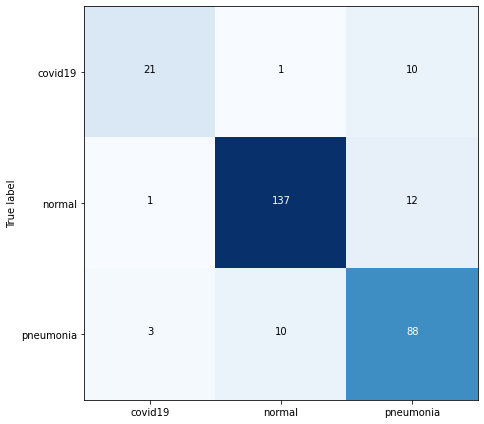

In [31]:
plt = plot_confusion_matrix(cm = cf, 
                      normalize    = False,
                      target_names = ["covid19", "normal", "pneumonia"],
                      title        = "")
plt.savefig('../docs/' + model.name + '.png')